In [ ]:
import pandas as pd
import numpy as np
from numpy import array, argmax, asarray, zeros
from random import randint
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_md", disable=["ner", "tagger", "parser", "attribute_ruler"])
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('pet_data_clean.csv', index_col = 0)
data.head()

,Review,Negative
0,pet need natural stuff smell great safe use ar...,0
1,excellent,0
2,works great easy use clean,0
3,harness impossible get dog correctly,1
4,electronic door dog work great let need go dau...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40008 entries, 0 to 40007
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    39986 non-null  object
 1   Negative  40008 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.7+ KB


In [ ]:
#drop rows that contain NaN
data = data.dropna()
data.shape

(39986, 2)

## Baseline Model

- First, build a simple linear model as baseline
- Choose to build a logistic regression using word2vec embeddings from spacy

In [ ]:
# Calculate embedding vectors
embedding= pd.DataFrame(data['Review'].apply(lambda text: nlp(text).vector))
embedding = pd.DataFrame(embedding['Review'].to_list())

# Specific independent variable
y = data[['Negative']]

/Users/wangbufan/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


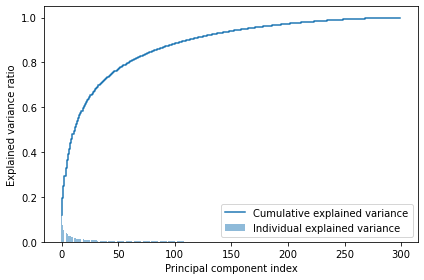

In [ ]:
# 96 features are too many for only 39986 data point. Thus, conduct PCA to reduce dimensions
from sklearn.decomposition import PCA

# Find optimal PCA dimension
pca = PCA()
X = pca.fit_transform(embedding)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
# Choose dimensions of 50 as the explained variance is around 80%
pca = PCA(n_components=50)
X = pca.fit_transform(embedding)

### Logistic Regression Model

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,stratify = y, shuffle = True, random_state = 40)

In [ ]:
# Build logistic regression model on training data
lr_embedding = LogisticRegression()
lr_embedding.fit(X_train, y_train)

/Users/wangbufan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [ ]:
# Predict/validate on testing data
y_train_embedding = lr_embedding.predict(X_train)
y_predict_embedding = lr_embedding.predict(X_test)

# Calculate ROC AUC score
print(f'Training AUC:{roc_auc_score(y_train, y_train_embedding)}')
print(f'Testing AUC:{roc_auc_score(y_test, y_predict_embedding)}')

Training AUC:0.7414053007031449
Testing AUC:0.7423968196082139


- Did not conduct hyperparameter tuning for the logistic regression model as the model is just a baseline
- For all of the following model: MLP, RNN, and LSTM, conduct hyperparameter tuning
- Manually change hyperparameter values to gradually increase the complexity of the model and observe the performance of training and testing data. Stop increasing the complexity of model when performance on testind data stop increasing and start decreasing, while the performance of training data keep increasing. The optimal model should output a decent high testing score which just a little bit below the training score
- Decided not to use GridSearch as it is time-consuming. Also, by manually chaning hyperparameters, we have overall more control of our model.

## MLP(multi-layer perceptron) model 

In [ ]:
# Set up MLP model
mlp = MLPClassifier(hidden_layer_sizes = (25,20),activation = 'relu', solver = 'adam', alpha = 0.01, learning_rate_init = 0.01)

In [ ]:
# Build MLP model, conduct 3 times cross-validation for a robust result
roc_auc_train = []
roc_auc_test = []
for i in range(3):
    # each loop randomly split the dataset into training and testing.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,stratify = y, shuffle = True)
    
    # Fit training data
    mlp.fit(X_train,y_train)
    
    # get predicted y
    y_predict_train = mlp.predict(X_train)
    y_predict_test = mlp.predict(X_test)
    
    # calculate auc
    roc_auc_train.append(roc_auc_score(y_train, y_predict_train))
    roc_auc_test.append(roc_auc_score(y_test, y_predict_test))
    
    print(f'Training AUC: {roc_auc_score(y_train, y_predict_train)}, Testing AUC: {roc_auc_score(y_test, y_predict_test)}')
    # Calculate average auc
    roc_auc_train_average = np.mean(roc_auc_train)
    roc_auc_test_average = np.mean(roc_auc_test)

print(f'Average Training AUC: {roc_auc_train_average}, Average Testing AUC: {roc_auc_test_average}')
    
    
    
    
    

/Users/wangbufan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training AUC: 0.8565832472093916, Testing AUC: 0.8159054856955906


/Users/wangbufan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training AUC: 0.8595564999373375, Testing AUC: 0.8261454858156507


/Users/wangbufan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training AUC: 0.8596587898779424, Testing AUC: 0.8146411028719874
Average Training AUC: 0.8585995123415572, Average Testing AUC: 0.8188973581277429


## RNN & LSTM 

- The following code is from Professor Chen's notebook 'Using RNNs and LSTMs'

### Tokenize Text

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(data['Review'])

In [ ]:
MAX_SEQUENCE_LENGTH = 100

def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# integer encode the documents
encoded_docs = integer_encode_documents(data['Review'], tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
# Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
# change target format for keras model
labels = to_categorical(data['Negative'])

### Load in GloVe Vectors

In [ ]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 307742 word vectors.


### Load in Embeddings

In [ ]:
# create a weight matrix for words in training docs
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

### Set up Model

In [ ]:
def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=56, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model


def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

### Fit the Model (RNN)

- Given that the number of data point is limited, decided not to split into training and testing.
- Rather, using the validation_split function to randomly validate on a subset of data

In [ ]:
model = make_binary_classification_rnn_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 80, 100)           1927000   
                                                                 
 masking_4 (Masking)         (None, 80, 100)           0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 56)                8792      
                                                                 
 dense_8 (Dense)             (None, 16)                912       
                                                                 
 dense_9 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,936,738
Trainable params: 9,738
Non-trainable params: 1,927,000
_________________________________________________________________


In [ ]:
# Set up earlystop to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# fit the model
history = model.fit(padded_docs, labels,validation_split = 0.1, epochs=10, verbose=1, callbacks = [callback])

Epoch 1/10
1125/1125 [==============================] - 53s 45ms/step - loss: 0.5879 - auc: 0.7549 - val_loss: 0.6940 - val_auc: 0.6546
Epoch 2/10
1125/1125 [==============================] - 42s 37ms/step - loss: 0.5240 - auc: 0.8160 - val_loss: 0.7455 - val_auc: 0.6103
Epoch 3/10
1125/1125 [==============================] - 43s 38ms/step - loss: 0.4887 - auc: 0.8441 - val_loss: 0.4380 - val_auc: 0.8950
Epoch 4/10
1125/1125 [==============================] - 43s 38ms/step - loss: 0.4708 - auc: 0.8565 - val_loss: 0.5071 - val_auc: 0.8389
Epoch 5/10
1125/1125 [==============================] - 43s 38ms/step - loss: 0.4340 - auc: 0.8801 - val_loss: 0.4939 - val_auc: 0.8470
Epoch 6/10
1125/1125 [==============================] - 42s 37ms/step - loss: 0.4095 - auc: 0.8946 - val_loss: 0.3510 - val_auc: 0.9305
Epoch 7/10
1125/1125 [==============================] - 42s 38ms/step - loss: 0.3914 - auc: 0.9041 - val_loss: 0.5525 - val_auc: 0.8061
Epoch 8/10
1125/1125 [==========================

### Fit the Model (LSTM)

In [ ]:
model = make_lstm_classification_model()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          1927000   
                                                                 
 masking_6 (Masking)         (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1,970,314
Trainable params: 43,314
Non-trainable params: 1,927,000
_________________________________________________________________


In [ ]:
# Set up earlystop to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# fit the model
history = model.fit(padded_docs, labels,validation_split = 0.1, epochs=10, verbose=1, callbacks = [callback])

Epoch 1/10
1125/1125 [==============================] - 189s 164ms/step - loss: 0.5180 - auc: 0.8203 - val_loss: 0.6440 - val_auc: 0.7080
Epoch 2/10
1125/1125 [==============================] - 185s 164ms/step - loss: 0.4311 - auc: 0.8815 - val_loss: 0.4351 - val_auc: 0.8813
Epoch 3/10
1125/1125 [==============================] - 185s 164ms/step - loss: 0.3650 - auc: 0.9170 - val_loss: 0.4611 - val_auc: 0.8672
Epoch 4/10
1125/1125 [==============================] - 184s 164ms/step - loss: 0.3028 - auc: 0.9439 - val_loss: 0.2930 - val_auc: 0.9512
Epoch 5/10
1125/1125 [==============================] - 184s 163ms/step - loss: 0.2400 - auc: 0.9649 - val_loss: 0.2193 - val_auc: 0.9717
Epoch 6/10
1125/1125 [==============================] - 184s 163ms/step - loss: 0.1895 - auc: 0.9779 - val_loss: 0.1322 - val_auc: 0.9897
Epoch 7/10
1125/1125 [==============================] - 183s 163ms/step - loss: 0.1465 - auc: 0.9866 - val_loss: 0.1086 - val_auc: 0.9918
Epoch 8/10
1125/1125 [============